In [1]:
import os
import re 
from pathlib import Path
from itertools import product 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

In [2]:
def df_from_videos(path):
    df=pd.DataFrame(columns=['episode','ckpt','distance_to_goal','SR','SPL','collisions_count'])
    p=Path(path)
    file_list = [item.name for item in list(p.glob('*.mp4'))]
    data=list()
    for i in file_list:
        data.append(re.findall(r"\d+\.?\d*",i)[:-1])
    for i in range(len(data)):
        df.loc[i]=data[i]
    return df.astype(str).astype(float)

In [3]:
FIG_SZ = (8,6)
FIG_DIR = "./figs"
base_dir = Path('./video/')

color_list = ["b", "r","g" ,"c", "m", "y", "k"]
agent_names = ["Baseline", "Mid_K", "Mid_KD", "Mid_KE", "Mid_KN", "Mid_KNC"]
corruptions = ["None", "Speckle Noise", "Motion Blur", "Noise & Blur"]
metric_names = ["distance_to_goal", "collisions_count", "SR", "SPL"]
titles = ["Distance to Goal (m)", "Number of Collisions", "Success Rate", "Success Weighted by Path Length"]

In [4]:
def form_file_name(agent, cor):
    feature_mapping = {"Baseline": "baseline", 
                        "Mid_K": "mid_kp3d", 
                        "Mid_KD": "mid_kp3d_deno", 
                        "Mid_KE": "mid_kp3d_edge", 
                        "Mid_KN": "mid_kp3d_norm", 
                        "Mid_KNC": "mid_kp3d_norm_curv"}
    corruption_mapping = {"None":"", 
                        "Speckle Noise":"cor_N", 
                        "Motion Blur":"cor_M", 
                        "Noise & Blur":"cor_M_N"}
    a = feature_mapping[agent]
    b = corruption_mapping[cor]

    return  "{}_{}".format(a, b).rstrip("_") + ".csv"

In [5]:
def get_agent_performance(df):
    """ get the "SR", "SPL", "collisions_count", "distance_to_goal" 
        of an agent based on the dataframe 

        returns a dict whose keys are "SR", "SPL", "collisions_count", "distance_to_goal" 
    """

    groups = df.groupby("ckpt")
    ckpt_nums = np.sort(np.unique(df["ckpt"]))

    metric_lists = [[] for _ in range(4)]
    agent_performance = {name:data_list for name, data_list in zip(metric_names, metric_lists)}

    for ckpt in ckpt_nums:
        this_group = groups.get_group(ckpt)
        group_mean = this_group.mean()
        group_var  = this_group.var() 
        for name in metric_names:
            # checkpoint number, mean and std of the metric
            agent_performance.get(name).append((ckpt, group_mean[name], np.sqrt(group_var[name])))

    # a dict, element format is {metric_name:List[Tuple(checkpoint number, mean, variance)]}
    return agent_performance

In [6]:
results_per_corruption = {cor:{agent:None for agent in agent_names} for cor in corruptions}
for cor, performances in results_per_corruption.items():
    for agent, perf in performances.items():
        csvfile = base_dir / form_file_name(agent, cor)
        df = pd.read_csv(csvfile)
        results_per_corruption[cor][agent] = get_agent_performance(df)
        
print(results_per_corruption.keys())
print(results_per_corruption["None"].keys())
print(results_per_corruption["None"]["Baseline"].keys() )

dict_keys(['None', 'Speckle Noise', 'Motion Blur', 'Noise & Blur'])
dict_keys(['Baseline', 'Mid_K', 'Mid_KD', 'Mid_KE', 'Mid_KN', 'Mid_KNC'])
dict_keys(['distance_to_goal', 'collisions_count', 'SR', 'SPL'])


In [7]:
def add_data_plot(data, color="r", label="None", draw_var=True):
    xs, mean, std = data[:, 0], data[:, 1], data[:, 2]
    plt.plot(xs, mean, color=color, label=label)
    if draw_var:
        plt.plot(xs, mean + 0.5*std, color=color, linestyle="--")
        plt.plot(xs, mean - 0.5*std, color=color, linestyle="--")
        plt.fill_between(xs, mean - 0.5*std, mean + 0.5*std, color=color, alpha=0.25)

In [8]:
def draw_metric_plot(data_list, color_list, labels, title, save=False):
    fig = plt.figure(figsize=FIG_SZ)
    for data, color, label in zip(data_list, color_list, labels):
        add_data_plot(data, color, label, draw_var=False)
    plt.title(title, fontsize=14);
    plt.xlabel("Checkpoint Number");
    # plt.ylabel("Metric Value")
    plt.legend();
    if save:
        plt.savefig("{}/{}.pdf".format(FIG_DIR, title), bbox_inches="tight")
    plt.show() 

In [9]:
def mean_performance_of_last_ckpt(data_list, agent_names, plot_title, num_last=10):
    
    for data, agent in zip(data_list, agent_names):
        xs, mean, std = data[:, 0], data[:, 1], data[:, 2]
        print("Agent {} has average {} at {:.3f} during last {} checkpoints".format(
                    agent, plot_title,np.mean(mean[-num_last:]), num_last))
        

when corruption is None
when corruption is None
when corruption is None


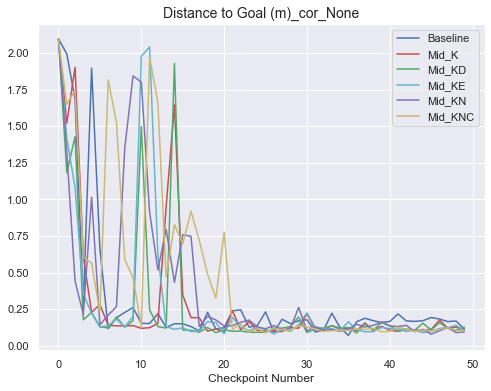

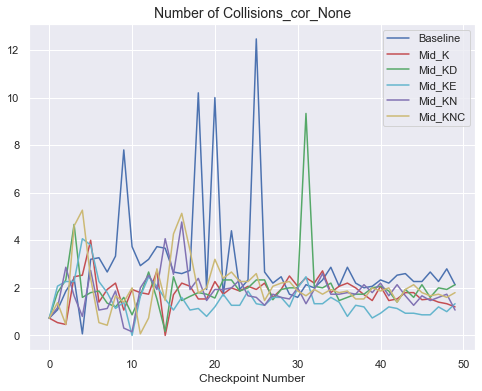

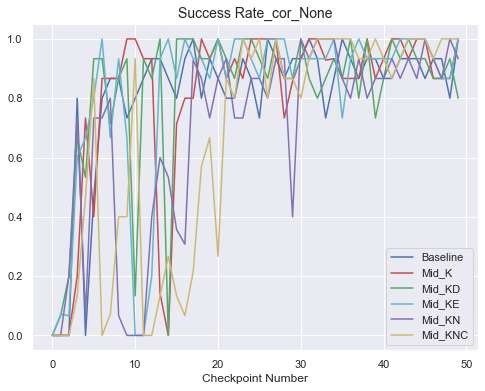

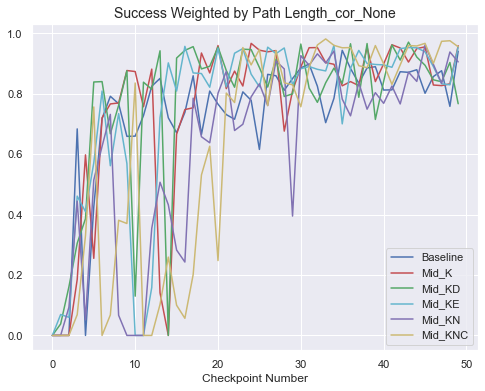

when corruption is Speckle Noise
when corruption is Speckle Noise
when corruption is Speckle Noise


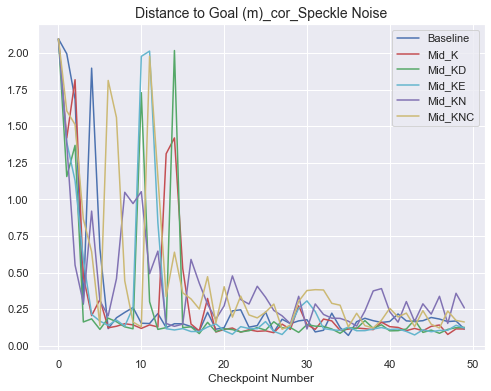

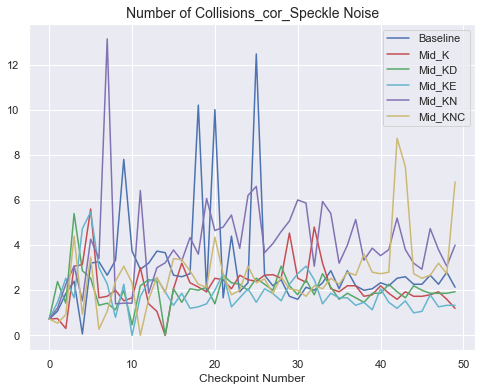

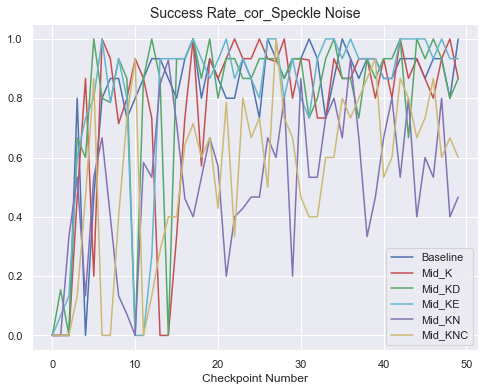

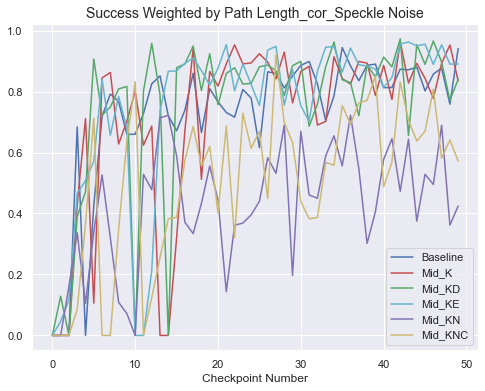

when corruption is Motion Blur
when corruption is Motion Blur
when corruption is Motion Blur


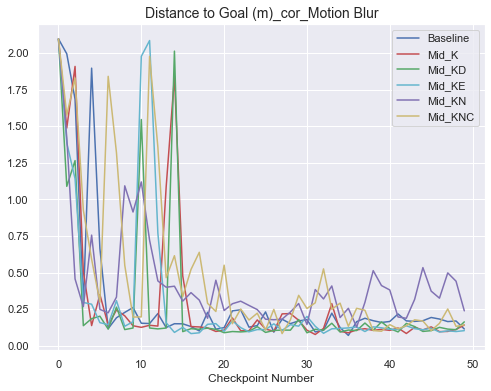

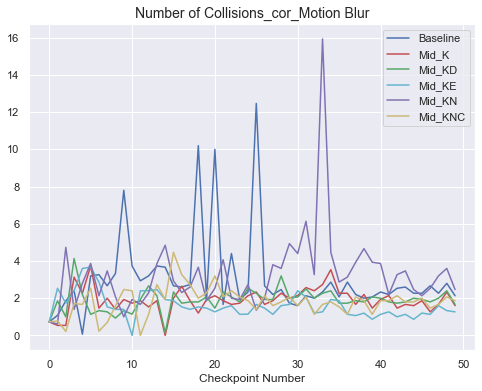

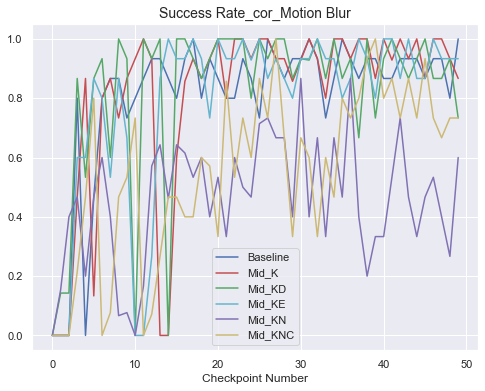

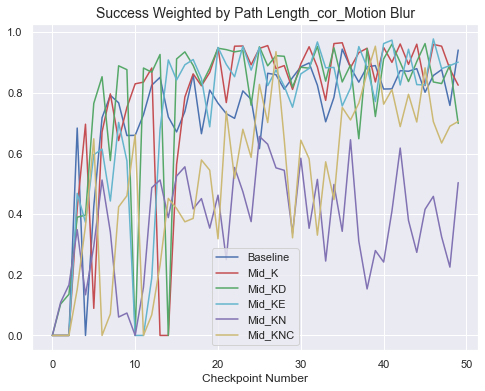

when corruption is Noise & Blur
when corruption is Noise & Blur
when corruption is Noise & Blur


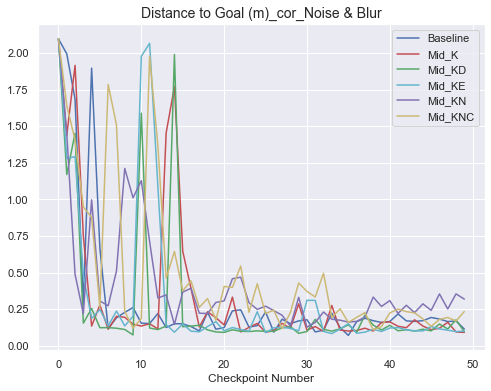

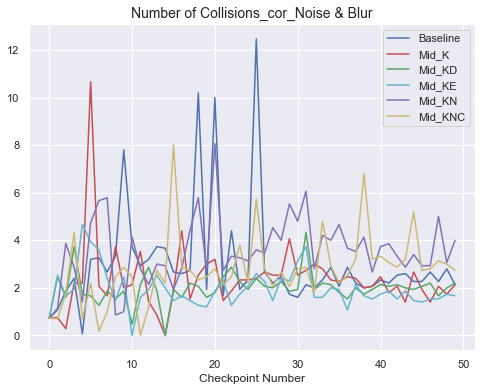

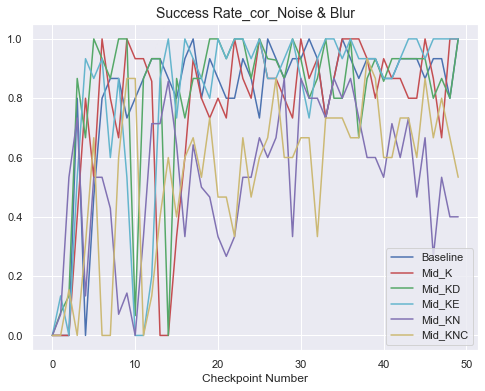

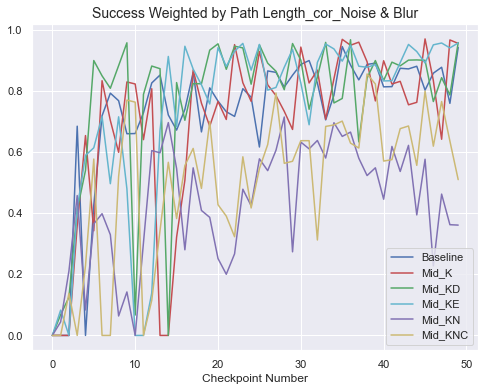

In [10]:
for cor in corruptions:
    all_agent_perf = results_per_corruption[cor]
    print("when corruption is {}".format(cor))
    print("when corruption is {}".format(cor))
    print("when corruption is {}".format(cor))
    for metric, plot_title in zip(metric_names, titles):
        # print(metric, plot_title)
        # draw the metric 
        data_list = [np.array(all_agent_perf[agent][metric]) for agent in agent_names]
        draw_metric_plot(data_list, color_list, labels=agent_names, title=plot_title+"_cor_{}".format(cor), save=True)

In [11]:
for cor in corruptions:
    all_agent_perf = results_per_corruption[cor]
    print("when corruption is {}".format(cor))
    print("when corruption is {}".format(cor))
    print("when corruption is {}".format(cor))
    for metric, plot_title in zip(metric_names, titles):
        # print(metric, plot_title)
        # draw the metric 
        data_list = [np.array(all_agent_perf[agent][metric]) for agent in agent_names]
        mean_performance_of_last_ckpt(data_list, agent_names, plot_title, num_last=10)

when corruption is None
when corruption is None
when corruption is None
Agent Baseline has average Distance to Goal (m) at 0.172 during last 10 checkpoints
Agent Mid_K has average Distance to Goal (m) at 0.117 during last 10 checkpoints
Agent Mid_KD has average Distance to Goal (m) at 0.123 during last 10 checkpoints
Agent Mid_KE has average Distance to Goal (m) at 0.111 during last 10 checkpoints
Agent Mid_KN has average Distance to Goal (m) at 0.111 during last 10 checkpoints
Agent Mid_KNC has average Distance to Goal (m) at 0.109 during last 10 checkpoints
Agent Baseline has average Number of Collisions at 2.407 during last 10 checkpoints
Agent Mid_K has average Number of Collisions at 1.563 during last 10 checkpoints
Agent Mid_KD has average Number of Collisions at 1.867 during last 10 checkpoints
Agent Mid_KE has average Number of Collisions at 1.040 during last 10 checkpoints
Agent Mid_KN has average Number of Collisions at 1.647 during last 10 checkpoints
Agent Mid_KNC has avera